In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    ! git clone https://github.com/fenglinglwb/MAT.git && \
     mkdir -p /content/MAT/pretrained && \
     cp /content/drive/MyDrive/Repo/GANs/INPAINTING/CelebA-HQ_512.pkl /content/MAT/pretrained && \
     cp /content/drive/MyDrive/Repo/GANs/INPAINTING/masked_video.mp4 /content && \
     cp /content/drive/MyDrive/Repo/GANs/INPAINTING/images/image.png /content && \
     pip -q install -r /content/MAT/requirements.txt

Mounted at /content/drive
Cloning into 'MAT'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 199 (delta 40), reused 43 (delta 37), pack-reused 151
Receiving objects: 100% (199/199), 18.89 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (84/84), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.7 MB/s eta 0:00:00


In [3]:
# For SimSwap
!pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 torchtext==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 727.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled t

In [63]:
import re
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

## Inpainting

In [57]:
root_path = Path('/content')
video_path = root_path.joinpath('masked_video.mp4')
%cd /content/MAT
!mkdir frames
MAT_path = root_path.joinpath('MAT')
data_path = Path('/content/MAT/frames')

/content/MAT


In [59]:
vidcap = cv2.VideoCapture(str(video_path))
success, image = vidcap.read()
count = 0
frames = []
while success:
    frames.append(
        cv2.imwrite(str(data_path.joinpath(f"frame{count}.png")), image)
    )  # save frame as JPEG file
    success, image = vidcap.read()
    print("Read a new frame: ", success, end=" ")
    count += 1

Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame:  True Read a new frame

In [62]:
files = [fname for fname in os.listdir(data_path) if fname.endswith(".png")]

In [65]:
def natural_sort_key(s, _nsre=re.compile("([0-9]+)")):
    return [int(text) if text.isdigit() else text.lower() for text in _nsre.split(s)]


files = sorted(files, key=natural_sort_key)

### Тест на одном изображении

In [68]:
image = cv2.imread(os.path.join(data_path, "frame0.png"))

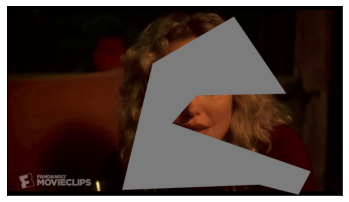

In [69]:
fig = plt.imshow(image[:, :, ::-1])
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

На протяжении всего видео актриса практически неподвижна, поэтому кроп для всех кадров будет одинаков

In [10]:
x_f, x_s = 500, 1800
y_f, y_s = 0, image.shape[1]

In [11]:
cropped = image[y_f:y_s, x_f:x_s, :]
cropped.shape

(1080, 1300, 3)

In [12]:
scale = 1
dim = (scale * 512, scale * 512)

In [13]:
resized = cv2.resize(cropped, dim, interpolation=cv2.INTER_CUBIC)
resized.shape

(512, 512, 3)

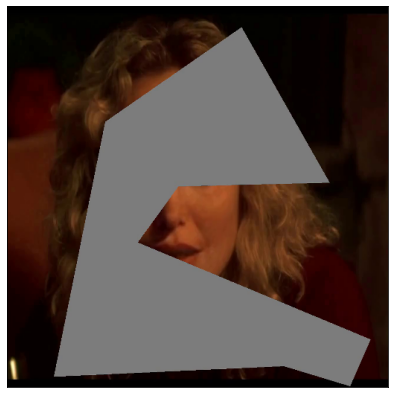

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(resized[:, :, ::-1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [18]:
!mkdir -p /content/MAT/one_frame
%cd /content/MAT/one_frame
!mkdir img mask
%cd ..
cv2.imwrite(str(MAT_path.joinpath("one_frame/img/image.png")), resized)

/content/MAT/one_frame
mkdir: cannot create directory ‘img’: File exists
mkdir: cannot create directory ‘mask’: File exists
/content/MAT


True

In [19]:
# Draw the mask
contours = np.array(
    [
        [1300, 60],
        [835, 328],
        [660, 1050],
        [1444, 1020],
        [1670, 1077],
        [1740, 945],
        [945, 670],
        [1085, 510],
        [1600, 500],
    ]
)
mask_base = np.zeros(image.shape, dtype=np.uint8)

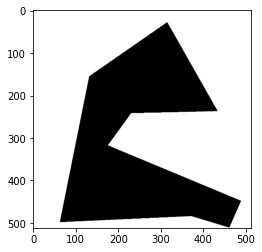

In [20]:
mask = cv2.fillPoly(~mask_base, pts=[contours], color=((0, 0, 0)))
cropped_mask = mask[y_f:y_s, x_f:x_s, :]
resized_mask = cv2.resize(cropped_mask, dim, interpolation=cv2.INTER_CUBIC)
plt.imshow(resized_mask[:, :, ::-1])

In [21]:
cv2.imwrite(str(MAT_path.joinpath("one_frame/mask/mask.png")), resized_mask)

True

In [23]:
%cd /content/MAT
!python generate_image.py \
--network pretrained/CelebA-HQ_512.pkl \
--dpath one_frame/img \
--mpath one_frame/mask \
--outdir samples

/content/MAT
Loading data from: one_frame/img
Loading mask from: one_frame/mask
Loading networks from: pretrained/CelebA-HQ_512.pkl
Prcessing: image.png
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


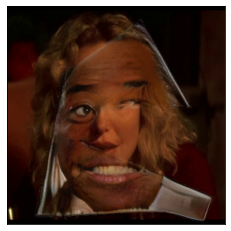

In [26]:
image = cv2.imread(str(MAT_path.joinpath("samples/image.png")))
fig = plt.imshow(image[:, :, ::-1])
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### Обработка всех кадров

In [74]:
%cd /content/MAT
! mkdir frames_mask resized_frames left_part

/content/MAT


In [79]:
for f in files:
    # Deal with frames
    image = cv2.imread(os.path.join(data_path, f))
    cropped = image[y_f:y_s, x_f:x_s, :]
    resized = cv2.resize(cropped, dim, interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(str(MAT_path.joinpath(f"resized_frames/{f}")), resized)
    # Deal with mask
    cv2.imwrite(str(MAT_path.joinpath(f"frames_mask/mask_{f}.png")), resized_mask)

In [80]:
!python generate_image.py \
--network pretrained/CelebA-HQ_512.pkl \
--dpath resized_frames \
--mpath frames_mask \
--outdir painted_frames

Loading data from: resized_frames
Loading mask from: frames_mask
Loading networks from: pretrained/CelebA-HQ_512.pkl
Prcessing: frame0.png
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Prcessing: frame1.png
Prcessing: frame10.png
Prcessing: frame100.png
Prcessing: frame101.png
Prcessing: frame102.png
Prcessing: frame103.png
Prcessing: frame104.png
Prcessing: frame105.png
Prcessing: frame106.png
Prcessing: frame107.png
Prcessing: frame108.png
Prcessing: frame109.png
Prcessing: frame11.png
Prcessing: frame110.png
Prcessing: frame111.png
Prcessing: frame112.png
Prcessing: frame113.png
Prcessing: frame114.png
Prcessing: frame115.png
Prcessing: frame116.png
Prcessing: frame117.png
Prcessing: frame118.png
Prcessing: frame119.png
Prcessing: frame12.png
Prcessing: frame120.png
Prcessing: frame121.png
Prcessing: frame122.png
Prcessing: frame123.png
Prcessing: frame124.png
Prcessing: frame125.png
Prcessing: frame126.png
Prcessing: fram

In [89]:
image_folder = MAT_path.joinpath("painted_frames")
video_path = root_path.joinpath("painted_video.mp4")

images = sorted(os.listdir(image_folder), key=natural_sort_key)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(
    str(video_path), cv2.VideoWriter_fourcc(*"XVID"), 26, (width, height)
)

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

### Эксперименты

Тестирование восстановления Анджелины Джоли по другим фотографиям в попытке выявить закономерности

In [121]:
!mkdir test
%cd test
!mkdir masks resized
%cd ..

mkdir: cannot create directory ‘test’: File exists
/content/MAT/test
mkdir: cannot create directory ‘masks’: File exists
mkdir: cannot create directory ‘resized’: File exists
/content/MAT


In [192]:
test_path = MAT_path.joinpath("test")

In [122]:
# Cropped Jolie images
!cp -R /content/drive/MyDrive/Repo/GANs/INPAINTING/images /content/MAT/test

In [125]:
files = [
    fname for fname in os.listdir("/content/MAT/test/images") if fname.endswith(".png")
]

In [126]:
# Resizing
for i, file in enumerate(files):
    image = cv2.imread(os.path.join("/content/MAT/test/images", file))
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join("/content/MAT/test/resized", file), resized)
    cv2.imwrite(str(MAT_path.joinpath(f"test/masks/mask{i}.png")), resized_mask)

In [127]:
%cd /content/MAT
!python generate_image.py \
--network pretrained/CelebA-HQ_512.pkl \
--dpath test/resized \
--mpath test/masks \
--outdir test/samples

/content/MAT
Loading data from: test/resized
Loading mask from: test/masks
Loading networks from: pretrained/CelebA-HQ_512.pkl
Prcessing: image0.png
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Prcessing: image1.png
Prcessing: image3.png
Prcessing: image4.png
Prcessing: image5.png
Prcessing: image6.png
Prcessing: image7.png
Prcessing: image8.png


Рандомная маска

In [129]:
!python generate_image.py \
--network pretrained/CelebA-HQ_512.pkl \
--dpath test/resized \
--outdir test/samples_random

Loading data from: test/resized
Loading networks from: pretrained/CelebA-HQ_512.pkl
Prcessing: image0.png
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Prcessing: image1.png
Prcessing: image3.png
Prcessing: image4.png
Prcessing: image5.png
Prcessing: image6.png
Prcessing: image7.png
Prcessing: image8.png


In [193]:
original_path = test_path.joinpath("resized")
our_mask_path = test_path.joinpath("samples")
random_mask_path = test_path.joinpath("samples_random")

In [194]:
original = sorted(
    [fname for fname in os.listdir(original_path) if fname.endswith(".png")],
    key=natural_sort_key,
)
original = [original_path.joinpath(item) for item in original]

our_mask = sorted(
    [fname for fname in os.listdir(our_mask_path) if fname.endswith(".png")],
    key=natural_sort_key,
)
our_mask = [our_mask_path.joinpath(item) for item in our_mask]

random_mask = sorted(
    [fname for fname in os.listdir(random_mask_path) if fname.endswith(".png")],
    key=natural_sort_key,
)
random_mask = [random_mask_path.joinpath(item) for item in random_mask]

In [195]:
images_paths = [
    item for tup in list(zip(original, our_mask, random_mask)) for item in tup
]

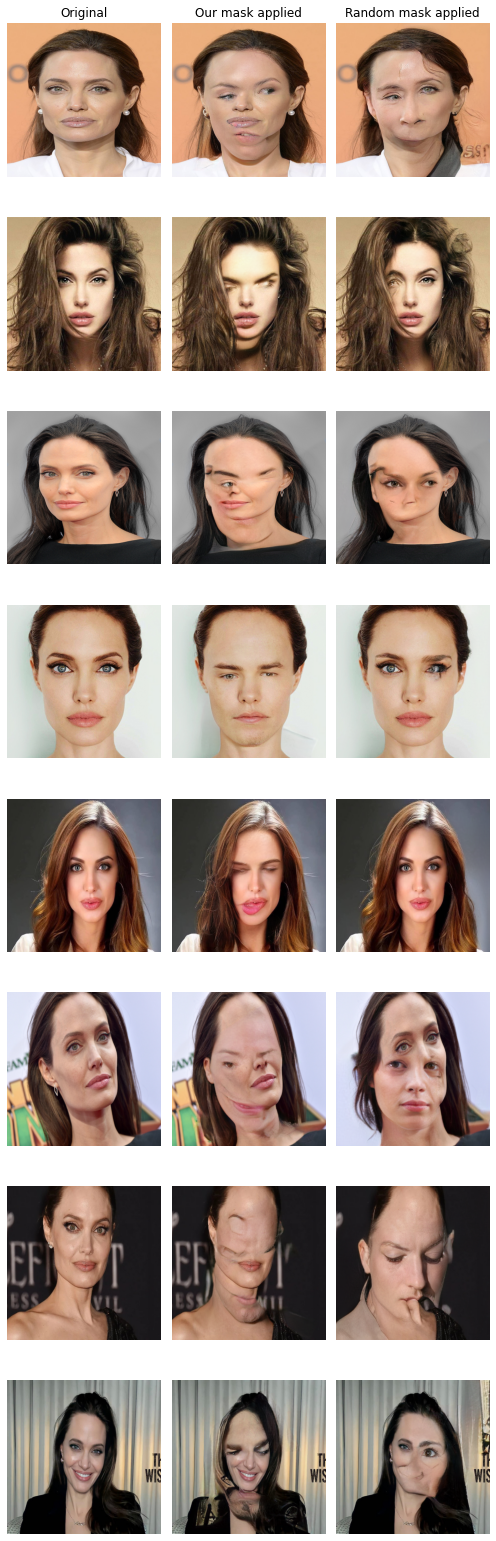

In [196]:
# Show results
images = []
for path in images_paths:
    image = cv2.imread(str(path))
    images.append(image)

cols = [item for item in ("Original", "Our mask applied", "Random mask applied")]

n_row, n_col = len(original), 3
_, axs = plt.subplots(n_row, n_col, figsize=(7, 22))
axs = axs.flatten()
for img, ax in zip(images, axs):
    ax.imshow(img[:, :, ::-1])
    ax.axis("off")

for ax, col in zip(axs[:n_row], cols):
    ax.set_title(col)
plt.tight_layout()
plt.show()

Результаты крайне ужасны, однако есть пример, когда наша маска сработала практически идеально и артефакты лишь затрагивают глаза (4): портрет в анфас, голова выверена по центру и занимает большую часть пространства. Также заметно, что есть примеры, где интуитивно кажется, что условия +- подходящие для успеха, но сетка справилась плохо - при этом при ресайзинге сломались пропорции и лица растянутые (1, 3). 2 пример доказывает, что обилие мелких деталей, перекрывающих лица, неимоверно приводят к ошибкам сетки. Нестандартные углы (7, 6) также не под силу. На 8 лицо занимает малое пространство картинки, скорее всего это главная причина неудачного инпейтинга.\
Плюсом видно, что артефакты порождаются и при масках совсем небольшого размера, так что это не самый важный фактор.

Теперь произведем inpainting для некоторых примеров из Celeba датасета

In [135]:
# Celeba images
!cp -R /content/drive/MyDrive/Repo/GANs/INPAINTING/celeba /content/MAT/test

In [139]:
files = [
    fname for fname in os.listdir("/content/MAT/test/celeba") if fname.endswith(".png")
]

In [143]:
# Resizing
! mkdir -p /content/MAT/test/celeba_resized
for file in files:
    image = cv2.imread(os.path.join('/content/MAT/test/celeba', file))
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join('/content/MAT/test/celeba_resized', file), resized)

In [146]:
%cd /content/MAT
!python generate_image.py \
--network pretrained/CelebA-HQ_512.pkl \
--dpath test/celeba_resized \
--mpath test/masks \
--outdir test/samples/celeba

/content/MAT
Loading data from: test/celeba_resized
Loading mask from: test/masks
Loading networks from: pretrained/CelebA-HQ_512.pkl
Prcessing: 0.png
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Prcessing: 1.png
Prcessing: 2.png
Prcessing: 3.png
Prcessing: 4.png
Prcessing: 5.png
Prcessing: 6.png
Prcessing: 7.png


Рандомная маска

In [ ]:
!python generate_image.py \
--network pretrained/CelebA-HQ_512.pkl \
--dpath test/celeba_resized \
--outdir test/samples_random/celeba

Loading data from: test/celeba_resized
Loading networks from: pretrained/CelebA-HQ_512.pkl
Prcessing: 0.png
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Prcessing: 1.png
Prcessing: 2.png
Prcessing: 3.png
Prcessing: 4.png
Prcessing: 5.png
Prcessing: 6.png
Prcessing: 7.png


In [172]:
original_path = test_path.joinpath("celeba_resized")
our_mask_path = test_path.joinpath("samples/celeba")
random_mask_path = test_path.joinpath("samples_random/celeba")

In [174]:
original = sorted(
    [fname for fname in os.listdir(original_path) if fname.endswith(".png")],
    key=natural_sort_key,
)
original = [original_path.joinpath(item) for item in original]

our_mask = sorted(
    [fname for fname in os.listdir(our_mask_path) if fname.endswith(".png")],
    key=natural_sort_key,
)
our_mask = [our_mask_path.joinpath(item) for item in our_mask]

random_mask = sorted(
    [fname for fname in os.listdir(random_mask_path) if fname.endswith(".png")],
    key=natural_sort_key,
)
random_mask = [random_mask_path.joinpath(item) for item in random_mask]

In [180]:
images_paths = [
    item for tup in list(zip(original, our_mask, random_mask)) for item in tup
]

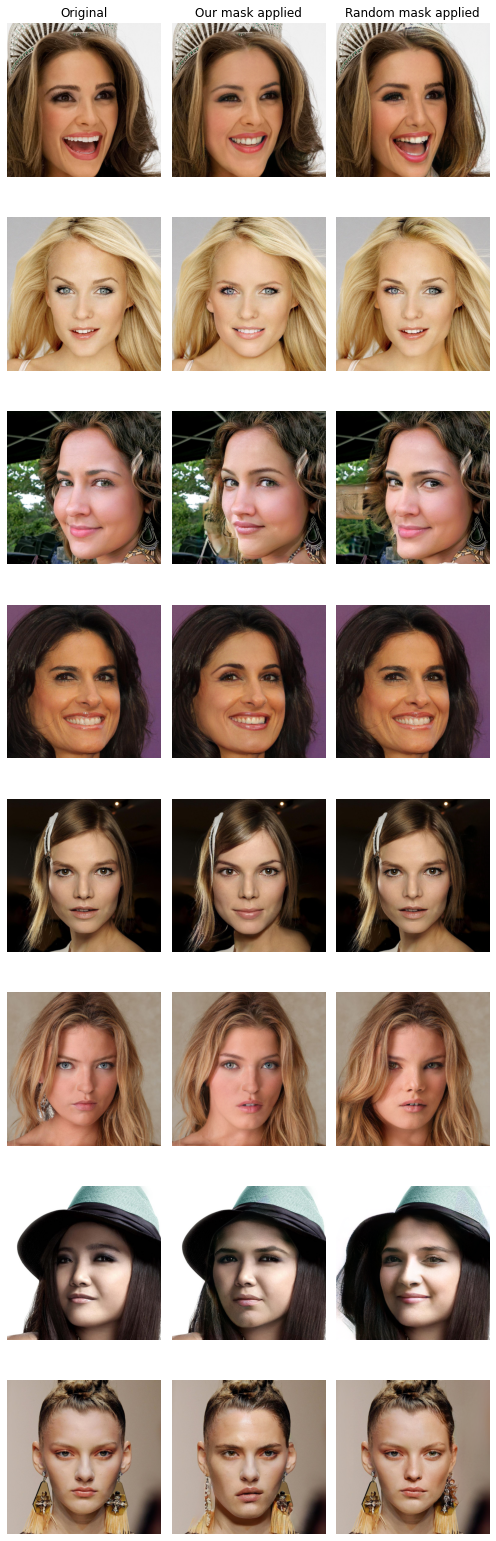

In [188]:
# Show results
images = []
for path in images_paths:
    image = cv2.imread(str(path))
    images.append(image)

cols = [item for item in ("Original", "Our mask applied", "Random mask applied")]

n_row, n_col = len(original), 3
_, axs = plt.subplots(n_row, n_col, figsize=(7, 22))
axs = axs.flatten()
for img, ax in zip(images, axs):
    ax.imshow(img[:, :, ::-1])
    ax.axis("off")

for ax, col in zip(axs[:n_row], cols):
    ax.set_title(col)
plt.tight_layout()
plt.show()

Где-то заметны небольшие артефакты, где-то практически идеально. Понятно, что эти кадры объединяет высокая детализация, хорошая освещенность и грамотное положение головы в кадре + высокий процент площади изображения, занимаемой конкретно головой/лицом. Причем чем больше лишних, мельтешащих на фоне объектов, тем хуже в этой области восстановление. С хорошими объектами нейросеть показывает отличный результат.

## Swapping

In [90]:
%cd ..

/content


In [91]:
! git clone https://github.com/neuralchen/SimSwap && \
 cp ./drive/MyDrive/Repo/GANs/INPAINTING/{checkpoints.zip,antelope.zip,512.zip} /content && \
 mkdir -p ./SimSwap/arcface_model ./SimSwap/insightface_func/models ./SimSwap/parsing_model/checkpoint && \
 unzip -q checkpoints.zip -d ./SimSwap/checkpoints && unzip -q antelope.zip -d ./SimSwap/insightface_func/models && \
 unzip -q 512.zip -d ./SimSwap/checkpoints && \
 cp ./drive/MyDrive/Repo/GANs/INPAINTING/arcface_checkpoint.tar ./SimSwap/arcface_model && \
 cp ./drive/MyDrive/Repo/GANs/INPAINTING/79999_iter.pth ./SimSwap/parsing_model/checkpoint

Cloning into 'SimSwap'...
remote: Enumerating objects: 1071, done.
remote: Total 1071 (delta 0), reused 0 (delta 0), pack-reused 1071
Receiving objects: 100% (1071/1071), 210.80 MiB | 18.18 MiB/s, done.
Resolving deltas: 100% (552/552), done.


In [92]:
! pip install insightface==0.2.1 onnxruntime moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [96]:
%cd /content/SimSwap

/content/SimSwap


In [97]:
import cv2
import torch
import fractions
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from models.models import create_model
from options.test_options import TestOptions
from insightface_func.face_detect_crop_multi import Face_detect_crop
from util.videoswap import video_swap
from util.add_watermark import watermark_image

In [98]:
transformer = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

transformer_Arcface = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

detransformer = transforms.Compose(
    [
        transforms.Normalize([0, 0, 0], [1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize([-0.485, -0.456, -0.406], [1, 1, 1]),
    ]
)

In [99]:
opt = TestOptions()
opt.initialize()
opt.parser.add_argument("-f")  ## dummy arg to avoid bug
opt = opt.parse()
opt.pic_a_path = "/content/image.png"
opt.video_path = "/content/painted_video.mp4"
opt.output_path = "/content/final_res.mp4"
opt.temp_path = "./tmp"
opt.Arc_path = "./arcface_model/arcface_checkpoint.tar"
opt.isTrain = False
opt.use_mask = True
opt.crop_size = 512
crop_size = opt.crop_size

torch.nn.Module.dump_patches = True
if crop_size == 512:
    opt.which_epoch = 550000
    opt.name = "512"
    mode = "ffhq"
else:
    mode = "None"

model = create_model(opt)
model.eval()

app = Face_detect_crop(name="antelope", root="./insightface_func/models")
app.prepare(ctx_id=0, det_thresh=0.6, det_size=(640, 640), mode=mode)

with torch.no_grad():
    pic_a = opt.pic_a_path
    # img_a = Image.open(pic_a).convert('RGB')
    img_a_whole = cv2.imread(pic_a)
    img_a_align_crop, _ = app.get(img_a_whole, crop_size)
    img_a_align_crop_pil = Image.fromarray(
        cv2.cvtColor(img_a_align_crop[0], cv2.COLOR_BGR2RGB)
    )
    img_a = transformer_Arcface(img_a_align_crop_pil)
    img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])

    # convert numpy to tensor
    img_id = img_id.cuda()

    # create latent id
    img_id_downsample = F.interpolate(img_id, size=(112, 112))
    latend_id = model.netArc(img_id_downsample)
    latend_id = latend_id.detach().to("cpu")
    latend_id = latend_id / np.linalg.norm(latend_id, axis=1, keepdims=True)
    latend_id = latend_id.to("cuda")

    video_swap(
        opt.video_path,
        latend_id,
        model,
        app,
        opt.output_path,
        temp_results_dir=opt.temp_path,
        use_mask=opt.use_mask,
        crop_size=crop_size,
    )

------------ Options -------------
Arc_path: models/BEST_checkpoint.tar
aspect_ratio: 1.0
batchSize: 8
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
crop_size: 224
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
f: /root/.local/share/jupyter/runtime/kernel-bbb6ce54-0237-4fdf-858e-b9b8160b869f.json
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
id_thres: 0.03
image_size: 224
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
latent_size: 512
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
multisepcific_dir: ./demo_file/multispecific
nThreads: 2
n_blocks_global: 6
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 3
n_local_enhancers: 1
name: people
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
no_simswaplogo: False
norm: batch
norm_G: spectralspadesyncbatch3x3
ntest: inf

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)

  warnings.warn(msg, SourceChangeWarning)



input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
(142, 366, 4)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/131 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(

100%|██████████| 131/131 [01:01<00:00,  2.13it/s]


Moviepy - Building video /content/final_res.mp4.
Moviepy - Writing video /content/final_res.mp4



Moviepy - Done !
Moviepy - video ready /content/final_res.mp4
